In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jaxopt
from jaxopt import ProjectedGradient
from scipy.signal import find_peaks, peak_widths
from jaxopt.objective import ridge_regression
from scipy.optimize import least_squares
jax.config.update("jax_enable_x64", True)
import cmath as cm
from PlotsSolver import Plotter
import time
from jaxopt.projection import projection_non_negative

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


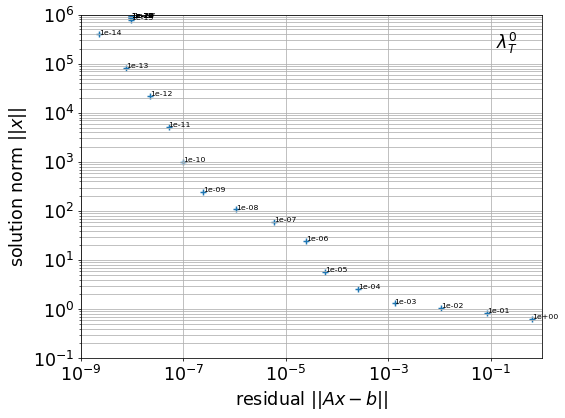

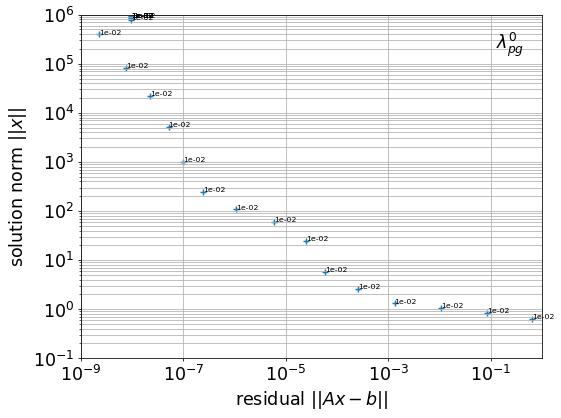

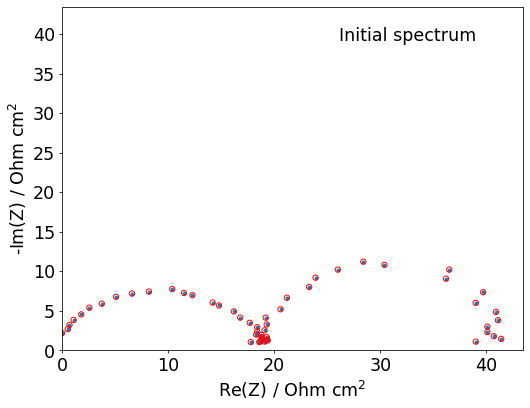

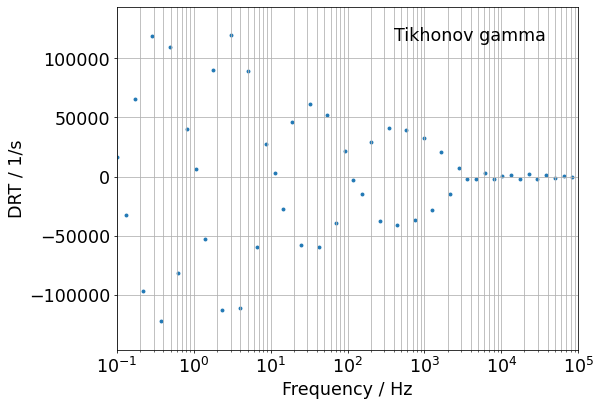

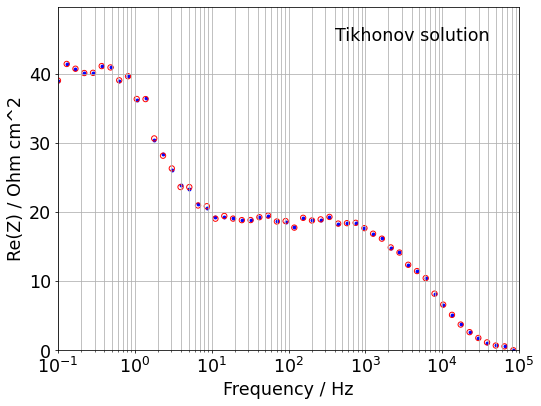

resparm.x = [5.05e-14 1.00e-02]
Projected gradient iterations = 80000 , rpol = 1.0452366244151174 , Rpol =  38.99
lamTfit, lampgfit = [5.05e-14 1.00e-02] , elapsed:  6.989306211471558  sec
Tikhonov residual: initial, final =  4.9570714429741965e-09 0.012767809295756957
Tikhonov lhs norm: initial, final = 37.41417448423271 37.41417193163088
Number of Jacobian evaluations = 1 , status = OK


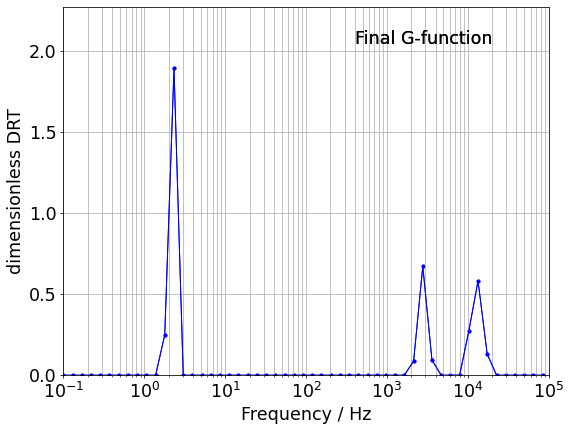

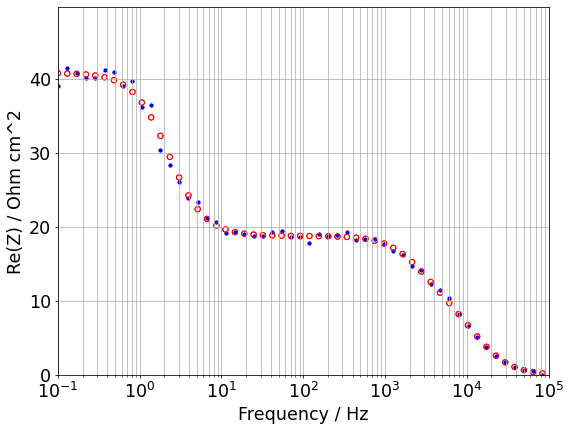

Peak frequencies (beta):    2.33000  2780.00000  13400.00000  
Peak polarizations (beta):  0.56365  0.48159  0.25826  


In [2]:



# --- For the main procedure and parameters see bottom part of this file

def ZWarburg():
    fmin = 0.01
    fmax = 1e5
    omega = np.zeros(1, dtype=np.float64)
    omega[0] = 2 * np.pi * fmin
    # alpha = 0.2328467394   # --- 11 points per decade
    alpha = 0.1103363182  # --- 22 points per decade
    # alpha = 0.07226722201  # --- 33 points per decade
    for n in range(1000):
        omega = np.append(omega, (1 + alpha) * omega[n])
        if omega[-1] > 2 * np.pi * fmax:
            break
    omega = np.delete(omega, -1)  # --- remove last omega from the array
    omega = np.flip(omega)        # --- reverse order of elements in omega
    print('omega max =', omega[0], ', omega size = ', omega.size)
    tast = 1
    zWarb = np.zeros(omega.size, dtype=np.complex128)
    for k in range(omega.size):
        psi = cm.sqrt(1j * tast * omega[k])
        zWarb[k] = cm.tanh(psi) / psi

    zrew = zWarb.real
    zimw = - zWarb.imag

    return omega, zrew, zimw   # --- omega is in descending order!



def user_data(path):
    data = pd.read_csv(
        path,
        sep=',',
    )
    dflat = data.to_numpy()
    omgu = dflat[:, 0] * 2 * np.pi
    zreu = dflat[:, 1]
    zimu = np.abs(dflat[:, 2])
    return omgu, zreu, zimu
# def user_data(path):
#     data = pd.read_csv(
#         path,
#         sep='\t',
#     )
#     dflat = data.to_numpy()
#     omgu = dflat[::-1][:, 0] * 2 * np.pi
#     zreu = dflat[::-1][:, 1]
#     zimu = np.abs(dflat[::-1][:, 2])
#     return omgu, zreu, zimu


# def user_data():
#     data = pd.read_csv(
#         './MyImpedance.dat',
#         sep=',', header=None
#     )
#     dflat = data.to_numpy()
#     omgu = dflat[:, 0] * 2 * np.pi
#     zreu = dflat[:, 1]
#     zimu = dflat[:, 2]
#     return omgu, zreu, zimu


# ---------------------------------------------------
# This part of the code should be changed
# in accordance with a user's problem.
# By default, calculation of Warburg finite--length
# DRT is performed.
# ---------------------------------------------------
#

fname = './results/Warburg_'   # --- Prefix for output files name
path = './immfit1.csv'
# path = 'data/zarc3_noise_005.txt'
# path = 'data/impedance_026.txt'
# path = 'data/zarc2_eis.txt'
lamT0 = 1e-14   # --- Initial guess for Tikhonov reg. parameter
lampg0 = 0.01   # --- Initial guess for PG reg. parameter
mode = 'real'   # --- Use real part of impedance for DRT calculation.
                # --- Set mode = 'imag' to use imaginary part.

# omg, zre, zim = ZWarburg()

# --- To supply your data, comment or remove the previous line and
# --- uncomment the next line:
omg, zre, zim = user_data(path)
# --- The file 'MyImpedance.dat' must be placed
# --- in the directory with python codes. This file
# --- must contain 3 columns separated by commas:
# ---       f(Hz),  zre,  zim
# --- frequencies f must be in descending order and
# --- zim must be positive.
# ---------------------------------------------------
# --- By default, the constrained TRF minimizer is used.
# --- To call Levenberg-Marquardt change the next
# --- line to: keylsq = 'lm'
keylsq = 'lm'
# ---------------------------------------------------

zre -= zre[0]
ub = jnp.array([1e-15, 1e-15])
lb = jnp.array([1e15, 1e15])


class TikhPGSolver:
    def __init__(self, zexp_re, zexp_im, omg, lamT0, lampg0, fname, mode='real'):
        self.rpol = zexp_re[-1] - zexp_re[0]
        self.zexp_re = zexp_re
        self.zexp_im = zexp_im
        self.zexp_re_norm = zexp_re / self.rpol
        self.zexp_im_norm = zexp_im / self.rpol
        self.omg = omg
        self.mode = mode
        self.lamT0 = lamT0
        self.lampg0 = lampg0
        self.niter = 80
        self.flagiter = 0
        self.fname = fname

        self.tau = 1 / self.omg
        self.lntau = jnp.log(self.tau)
        self.dlntau = self.create_dmesh(self.lntau)
        self.dtau = self.create_dmesh(self.tau)
        self.Idm = jnp.identity(self.omg.size, dtype=jnp.integer)
        self.am = jnp.zeros((self.omg.size, self.omg.size), dtype=jnp.float64)
        self.CreateTikhMatrix()
        self.jacobian = jax.jacobian(self.Tikh_residual)
        self.gfun_init = self.Tikh_solver(self.lamT0, self.amTam, self.brs, self.Idm)
        if mode == 'real':
            self.fsuffix = 'zre'
        else:
            self.fsuffix = 'zim'

    def create_dmesh(self, grid):
        dh = jnp.zeros(self.omg.size, dtype=jnp.float64)
        for j in range(1, self.omg.size - 1):
            dh = dh.at[j].set(0.5 * (grid[j + 1] - grid[j - 1]))
        dh = dh.at[0].set(0.5 * (grid[1] - grid[0]))
        dh = dh.at[-1].set(0.5 * (grid[-1] - grid[-2]))
        return dh

    # def create_dmesh(self, grid):
    #     num_points = grid.size
    #     dh = jnp.zeros(num_points, dtype=jnp.float64)

    #     # Use a second order central difference for interior points
    #     for j in range(2, num_points - 2):
    #         dh = dh.at[j].set((grid[j+1] - 2*grid[j-1] + grid[j-1]))

    #     # Use a higher order forward/backward difference for the boundaries
    #     dh = dh.at[0].set(2*grid[0] - 5*grid[1] + 4*grid[2] - grid[3])
    #     dh = dh.at[-1].set(-grid[-4] + 4*grid[-3] - 5*grid[-2] + 2*grid[-1])

    #     return dh



    def CreateTikhMatrix(self):   # --- creates lhs matrix and rhs vector
        for i in range(self.omg.size):
            prod = self.omg[i] * self.tau
            if self.mode == 'real':
                self.am = self.am.at[i, :].set(self.dlntau / (1 + prod**2))
            else:
                self.am = self.am.at[i, :].set(prod * self.dlntau / (1 + prod**2))

        self.amT = self.am.transpose()                    # --- transposed a-matrix
        self.amTam = jnp.matmul(self.amT, self.am)
        self.amTikh = self.amTam + self.lamT0 * self.Idm  # --- Tikhonov matrix

        if self.mode == 'real':
            self.brs = jnp.matmul(self.amT, self.zexp_re_norm)    # --- Tikhonov right side vector
        else:
            self.brs = jnp.matmul(self.amT, self.zexp_im_norm)    # --- Tikhonov right side vector

    def Tikh_solver(self, lamt, amTam, brs, Idm):
        amTikh = amTam + lamt * Idm  # --- new Tikhonov matrix
        sol, residuals, rank, sv = jnp.linalg.lstsq(amTikh, brs, rcond=0)  # --- Solve Tikhonov equation
        return sol


    def objective_fun(self, gtau, amTikh, brs):
        residuals = jnp.matmul(amTikh, gtau) - brs
        return jnp.sum(residuals ** 2)


    def pg_solver(self, lamvec, amTikh, amTam, brs, dlntau, Idm):
        lamT, lampg = lamvec  # these are the two regularization parameters
        gtau = self.Tikh_solver(lamT, amTam, brs, Idm)  # --- initial Gfun from Tikhonov solver
        amTikh = amTam + lamT * Idm  # ---

        pg = jaxopt.ProjectedGradient(fun=jax.jit(self.objective_fun),
                                    projection=jaxopt.projection.projection_non_negative,tol=1e-8,
                                    maxiter=self.niter * 1000, implicit_diff=True, jit=True)
        solution = pg.run(init_params=gtau, amTikh=amTikh, brs=brs)

        rpoly = jnp.sum(solution.params * dlntau)

        return solution.params, rpoly, solution.state.iter_num

    # def objective_fun(self, gtau, amTikh, brs, lampg):
    #     residuals = jnp.matmul(amTikh, gtau) - brs
    #     return jnp.sum(residuals ** 2)


    # def pg_solver(self, lamvec, amTikh, amTam, brs, dlntau, Idm):
    #     lamT, lampg = lamvec  # these are the two regularization parameters
    #     gtau = self.Tikh_solver(lamT, amTam, brs, Idm)  # --- initial Gfun from Tikhonov solver

    #     pg = jaxopt.ProjectedGradient(fun=jax.jit(self.objective_fun),
    #                                 projection=jaxopt.projection.projection_non_negative, tol=1e-8,
    #                                 maxiter=self.niter * 1000)
    #     solution = pg.run(init_params=gtau, amTikh=amTikh, brs=brs, lampg=lampg)

    #     rpoly = jnp.sum(solution.params * dlntau)

    #     return solution.params, rpoly, solution.state.iter_num










    def jacoby(self, pvec, amTikh, amTam, brs, dlntau, Idm):
        return (jax.jacobian(self.Tikh_residual)(jnp.array(pvec), amTikh, amTam, brs, dlntau, Idm))

    def Tikh_residual(self, lamvec, amTikh, amTam, brs, dlntau, Idm):   # --- returns vector of Tikhonov residuals to be minimized
        gfvec, rp, kk = self.pg_solver(lamvec, amTikh, amTam, brs, dlntau, Idm)   # --- (new amTikh has been calculated)
        resid = jnp.matmul(self.amTikh, gfvec) - self.brs
        return resid

    def Tikh_residual_norm(self, gtau, lamT, amTam, brs, Idm):    # --- returns mean Tikhonov residual
        amTikh = amTam + lamT * Idm    # --- Tikhonov matrix
        work = jnp.matmul(amTikh, gtau)
        sumres = jnp.sqrt(jnp.sum((work - brs)**2))
        sumlhs = jnp.sqrt(jnp.sum(work**2))
        return sumres, sumlhs

    def residual_norm(self, gtau):   # --- returns residual
        work = jnp.matmul(self.amTam, gtau)
        normres = jnp.sqrt(jnp.sum((work - self.brs)**2))
        return normres

    def Zmodel_imre(self, gtau):   # --- calculates model Im(Z)/Re(Z)
        zmod = jnp.zeros(self.omg.size, dtype=jnp.float64)
        for i in range(self.omg.size):
            prod = self.omg[i] * self.tau
            if self.mode == 'real':
                integrand = gtau / (1 + prod ** 2)
            else:
                integrand = prod * gtau / (1 + prod ** 2)
            zmod = zmod.at[i].set(jnp.sum(self.dlntau * integrand))  # --- my trapezoid
        return jnp.flip(self.rpol * zmod)

    def rpol_peaks(self, gtau):
        gtau_numpy = np.array(np.asarray(gtau))  # converting gtau to a writable numpy array
        peaks, dummy = find_peaks(gtau_numpy, prominence=0.01)
        width = peak_widths(gtau_numpy, peaks, rel_height=1)

        integr = jnp.zeros(peaks.size, dtype=jnp.float64)
        for n in range(peaks.size):
            lb, ub = int(width[2][n]), int(width[3][n])
            integr = integr.at[n].set(jnp.sum(gtau[lb:ub] * self.dlntau[lb:ub]))

        pparms = jnp.zeros((2, peaks.size), dtype=jnp.float64)
        pparms = pparms.at[0, :].set(jnp.flip(1 / (2 * jnp.pi * self.tau[peaks])))   # --- peak frequencies
        pparms = pparms.at[1, :].set(jnp.flip(integr))                   # --- peak polarization fractions
        return pparms

    def find_lambda(self):
        kmax, lam1 = 25, 1e-25
        solnorm = jnp.zeros(kmax, dtype=jnp.float64)
        resid = jnp.zeros(kmax, dtype=jnp.float64)
        lamT = jnp.zeros(kmax, dtype=jnp.float64)
        lampg = jnp.zeros(kmax, dtype=jnp.float64)
        for k in range(kmax):
            lam1 = lam1 * 10
            lamT = lamT.at[k].set(lam1)
            gfun = self.Tikh_solver(lam1, self.amTam, self.brs, self.Idm)
            resid = resid.at[k].set(self.residual_norm(gfun))
            solnorm = solnorm.at[k].set(jnp.sqrt(jnp.sum(gfun**2)))
            lampg = lampg.at[k].set(1 / jnp.linalg.norm(self.amTikh))
        return resid, solnorm, lamT, lampg

    def driver(self, lsq):   # --- omega must be in descending order!
        myplots = Plotter(self.zexp_re, self.zexp_im, self.omg, self.mode)

        resid, solnorm, arrlamT, arrlampg = self.find_lambda()
        myplots.plotLambda(resid, solnorm, arrlamT,
                           self.fname + '_lambda_T','$\lambda_T^0$', 0)
        myplots.plotLambda(resid, solnorm, arrlampg,
                           self.fname + '_lambda_PG', '$\lambda_{pg}^0$', 0)

        myplots.plotNyq(self.zexp_re - 1j * self.zexp_im, 'Initial spectrum')
        myplots.plotgamma(self.gfun_init, self.fname + '_init', 0, 'Tikhonov gamma')
        zmod = self.Zmodel_imre(self.gfun_init)
        myplots.plotshow_Z(zmod, self.fname + '_init' + self.fsuffix, 0, 'Tikhonov solution')

        start = time.time()
        lamvecinit = jnp.array([self.lamT0, self.lampg0], dtype=jnp.float64)
        low, high = lamvecinit / 10, lamvecinit * 10

        if lsq == 'trf':
            resparm = least_squares(jax.jit(self.Tikh_residual), lamvecinit,
                                    method='lm', jac=self.jacoby, args=(self.amTikh, self.amTam, self.brs, self.dlntau, self.Idm))

        else:
            resparm = least_squares(jax.jit(self.Tikh_residual), lamvecinit, bounds=(low, high),
                                     method='trf', jac=self.jacoby, args=(self.amTikh, self.amTam, self.brs, self.dlntau, self.Idm))

        res = resparm.x

        print(f"resparm.x = {res}")

        gfun, rpoly, nit = self.pg_solver(res, self.amTikh, self.amTam, self.brs, self.dlntau, self.Idm)
        # gamres = 2 * np.pi * self.fHz * gfun
        end = time.time()
        print('Projected gradient iterations =', nit, ', rpol =', rpoly,
              ', Rpol = ', self.rpol)
        print('lamTfit, lampgfit =', res, ', elapsed: ', (end - start), ' sec')

        resinit, lhsinit = self.Tikh_residual_norm(self.gfun_init, self.lamT0, self.amTam, self.brs, self.Idm)
        resfin , lhsfin  = self.Tikh_residual_norm(gfun, res[0], self.amTam, self.brs, self.Idm)
        print('Tikhonov residual: initial, final = ', resinit, resfin)
        print('Tikhonov lhs norm: initial, final =', lhsinit, lhsfin)
        if resparm.status > 0 :
            print('Number of Jacobian evaluations =', resparm.njev, ', status = OK')
        if self.flagiter == 1:
            print('Warning, limiting number of iterations is achieved')

        # myplots.plotgamma(gamres, self.fname + 'gamma', 1, '')
        myplots.plotGfun(gfun, self.fname + 'Gfun', 1, 'Final G-function')
        zmod = self.Zmodel_imre(gfun)
        myplots.plotshow_Z(zmod, self.fname + self.fsuffix, 1, '')


        peakparms = self.rpol_peaks(gfun)

        print('Peak frequencies (beta):   ', ''.join(['{:.5f}  '.format(item) for item in peakparms[0]]))
        print('Peak polarizations (beta): ', ''.join(['{:.5f}  '.format(item) for item in peakparms[1]]))



solver = TikhPGSolver(zre, zim, omg, lamT0, lampg0, fname, mode)
solver.driver(keylsq)